# Setup

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# import tensorflow as tf

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
# dataset: https://www.kaggle.com/ronitf/heart-disease-uci
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
# data = load_breast_cancer(as_frame=True)
# df = data.frame.copy()
# df.head()

In [7]:
# data.target_names

In [8]:
# iris2encoded = {k: v for k, v in zip(df.target.unique(), data.target_names)}
# iris2encoded

In [9]:
df['target'] = df.target.astype(int)

In [10]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [11]:
df.target.unique()

array([1, 0])

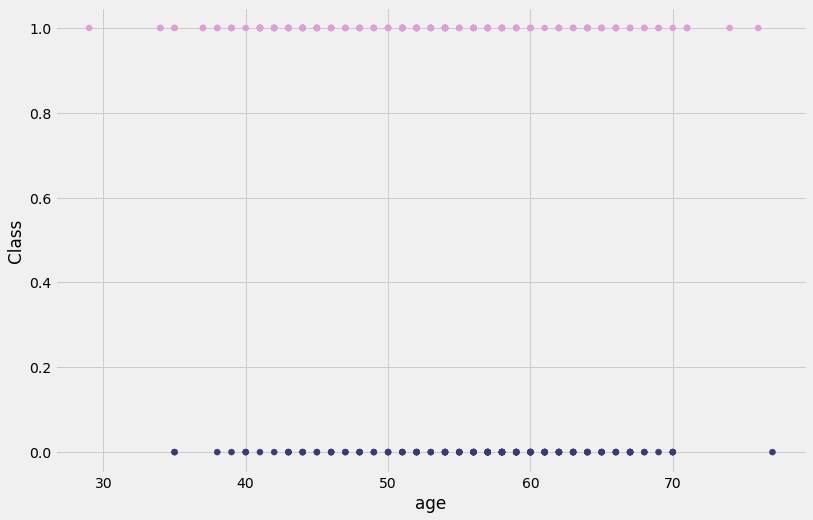

In [12]:
col_idx = 0
plt.scatter(df.iloc[:, col_idx], df.target, c=df.target, cmap='tab20b')
plt.xlabel(df.columns[col_idx])
plt.ylabel('Class');

# Preparing data

In [13]:
# X, y = data.data, data.target
# X.shape, y.shape

In [14]:
X = df.drop(columns='target')
y = df['target']
X.shape, y.shape

((303, 13), (303,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.shape, y_test.shape

((242,), (61,))

In [16]:
# VERY IMPORTANT STEP
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_train.shape, y_test.shape

((242, 1), (61, 1))

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
full_data = df.values
full_data.shape

(303, 14)

# Implementation

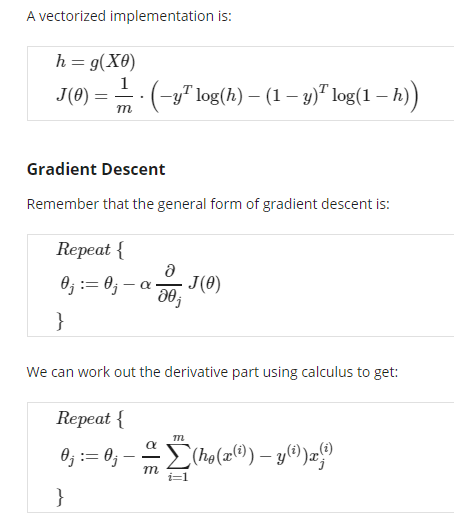

https://www.coursera.org/learn/machine-learning/supplement/0hpMl/simplified-cost-function-and-gradient-descent

<pre>
NOTE: Capital letters are used to denote variables in matrix form.
@ is the operator for matrix multiplication, also known as dot product.

- Need to use X @ W instead of W @ X due to the nature of matrix multiplication.
Best fit equation for logits: y_proba = X @ W + b
Cost function is cross-entropy loss, or log loss: 
J = (-1 / m) * (y.T @ np.log(y_proba) + (1 - y).T @ np.log(1 - y_proba))
  = (-1 / m) * (y.T @ np.log(X @ W + b) + (1 - y).T @ np.log(1 - X @ W - b))

- Dot product already includes the operation of summing up along the corresponding axis,
therefore np.sum is not required.

dW = (1 / m) * (X.T @ (y_proba - y))
db = (1 / m) * np.sum(y_proba - y)
</pre>

More references for deriving the derivatives: <br>
- https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d
- https://en.wikipedia.org/wiki/Cross_entropy
- https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [19]:
# set a seed for reproducible results
np.random.seed(42)

def init_params(X):
    """Randomly initializing parameters"""
    print("[INFO] Initialized parameters.")
    n_features = X.shape[1]  # number of features
    params = {}
    params['coef'] = np.random.randn(n_features, 1)  # the matrix for slope coefficients
    params['intercept'] = np.random.randn(1, 1)  # the y-intercept
    return params

def get_logits(X, params):
    return X @ params['coef'] + params['intercept']

def predict_proba(X, params):
    """
    Basically identical to sigmoid function, 
    also known as logistic function.
    Used to get probability for binary classification.
    """
    if 'coef' not in params:
        params = init_params(X)
    logits = get_logits(X, params)
    return 1 / (1 + np.exp(-logits))

def fit(X, y, learning_rate=0.05, iterations=1000):
    if isinstance(X, pd.DataFrame):
        # convert Dataframe to numpy for faster computations 
        X = X.values
    params = init_params(X)
    m = X.shape[0]  # number of samples
    
    print("[INFO] Training ...")
    for i in range(iterations):
        # make predictions by computing probability
        y_proba = predict_proba(X, params)
        
        # calculate gradients via derivatives with loss function (refer above)
        dW = (1 / m) * (X.T @ (y_proba - y))
        db = (1 / m) * np.sum(y_proba - y)
        
        # use gradient descent to update parameters
        # parameter = parameter - learning_rate * derivative_of_parameter
        params['coef'] -= (learning_rate * dW)
        params['intercept'] -= (learning_rate * db)
    
    return params

def predict(X, params, threshold=0.5):
    y_proba = predict_proba(X, params)
    y_pred = np.where(y_proba > threshold, 1, 0)
    return y_pred

In [20]:
y_train.shape

(242, 1)

In [21]:
params = fit(X_train, y_train, learning_rate=0.05, iterations=1000)
params['coef'].shape, params['intercept'].shape

[INFO] Initialized parameters.
[INFO] Training ...


((13, 1), (1, 1))

In [22]:
y_pred = predict(X_test, params)
y_pred.shape

(61, 1)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("My Implementation:")
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

My Implementation:
0.8524590163934426
[[25  4]
 [ 5 27]]


In [24]:
# penalty='none' for no regularization
# solver='sag' for closer result with normal gradient descent
log_reg = LogisticRegression(penalty='none', solver='sag', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
sk_y_pred = log_reg.predict(X_test)
print("Scikit-learn Implementation:")
print(accuracy_score(y_test, sk_y_pred))
print(confusion_matrix(y_test, sk_y_pred))

Scikit-learn Implementation:
0.8524590163934426
[[25  4]
 [ 5 27]]


In [25]:
log_reg = LogisticRegression(penalty='none', solver='sag', random_state=42)
np.mean(cross_val_score(log_reg, X_train, y_train, cv=5))

0.8179421768707483

## Comparing solvers

In [26]:
# referring https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
log_reg = LogisticRegression(C=1, random_state=42)
clf = GridSearchCV(log_reg, params, cv=5)
clf.fit(X_train, y_train.reshape(-1))
scores = clf.cv_results_['mean_test_score']

print("Solver\t\tAccuracy")
print("-" * 10 + "\t" + "-" * 8)
for score, solver in zip(scores, solver_list):
    print(f"{solver}     \t{score:.3f}" )

Solver		Accuracy
----------	--------
liblinear     	0.818
newton-cg     	0.818
lbfgs     	0.818
sag     	0.818
saga     	0.818


## Class approach

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MyLogisticRegBinary(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.params = {}
        self.verbose = 0

    def init_params(self, X):
        """Randomly initializing parameters"""
        n_features = X.shape[1]  # number of features
        # the matrix for slope coefficients
        self.params['coef'] = np.random.randn(n_features, 1)
        # the y-intercept
        self.params['intercept'] = np.random.randn(1, 1)
        if self.verbose:
            print("[INFO] Initialized parameters.")
            print(f"Shape of coefficient matrix: {self.params['coef'].shape}")
            print(f"Shape of intercept matrix: {self.params['intercept'].shape}")

    def get_logits(self, X, y=None):
        # logits = log(odds) = X@W + b
        if 'coef' not in self.params:
            # initialize the parameters if haven't
            self.init_params(X)
        return X @ self.params['coef'] + self.params['intercept']

    def predict_proba(self, X, y=None):
        """
        Sigmoid function, aka logistic function.
        Used to get probability for binary classification.
        """
        logits = self.get_logits(X)
        return 1 / (1 + np.exp(-logits))

    def fit(self, X, y, learning_rate=0.05, iterations=1000, verbose=0):
        # set verbose to 1 to see the entire training progress
        self.verbose = verbose
        
        if isinstance(X, pd.DataFrame):
            # convert Dataframe to numpy for faster computations 
            X = X.values
        # initialize parameters
        self.init_params(X)
        m = X.shape[0]  # number of samples
    
        if verbose:
            print("[INFO] Training ...")
        for i in range(1, iterations + 1):
            # make predictions by computing probability
            y_proba = self.predict_proba(X)
            
            # calculate the binary cross-entropy loss
            loss = - (1 / m) * np.sum(y * np.log(y_proba) \
                        + (1 - y) * np.log(1 - y_proba))

            # calculate gradients via derivatives 
            #  with respect to loss function (refer above)
            dW = (1 / m) * (X.T @ (y_proba - y))
            db = (1 / m) * np.sum(y_proba - y)

            # use gradient descent to update parameters
            # parameter = parameter - (learning_rate * derivative_of_parameter)
            self.params['coef'] -= (learning_rate * dW)
            self.params['intercept'] -= (learning_rate * db)
            
            if verbose and (i == 1 or i % 100 == 0):
                print(f"\nIteration {i}/{iterations}")
                print("--" * 12)
                print(f"Loss: {loss}")
                print(f"Coefficient:\n{self.params['coef']}")
                print(f"Intercept:\n{self.params['intercept']}")

    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        y_pred = np.where(y_proba > threshold, 1, 0)
        return y_pred
    
    def predict_score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [28]:
my_log_reg = MyLogisticRegBinary()
my_log_reg.fit(X_train, y_train, learning_rate=0.05, iterations=1000, verbose=0)
y_pred = my_log_reg.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("My implementation:")
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

My implementation:
0.8688524590163934
[[25  4]
 [ 4 28]]


In [30]:
# penalty='none' for no regularization
# solver='sag' for closer result with normal gradient descent
log_reg = LogisticRegression(penalty='none', solver='sag', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
sk_y_pred = log_reg.predict(X_test)
print("Scikit-learn implementation:")
print(accuracy_score(y_test, sk_y_pred))
print(confusion_matrix(y_test, sk_y_pred))

Scikit-learn implementation:
0.8524590163934426
[[25  4]
 [ 5 27]]


In [31]:
print("Cross-validation score:")
print(np.mean(cross_val_score(my_log_reg, X_train, y_train, cv=5)))
print(np.mean(cross_val_score(log_reg, X_train, y_train, cv=5)))

Cross-validation score:
0.8180272108843537
0.8179421768707483


## Multi-class classification

- Softmax in logistic regression: https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder

class MyLogisticReg(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.params = {}
        self.n_features = None
        self.n_class = None
        self.encoder = OneHotEncoder(sparse=False)
        self.verbose = 0

    def init_params(self, X, y):
        """Randomly initializing parameters"""
        self.n_features = X.shape[1]  # number of features
        # the matrix for slope coefficients
        self.params['coef'] = np.random.randn(self.n_features, self.n_class)
        # the y-intercept
        self.params['intercept'] = np.random.randn(1, self.n_class)
        if self.verbose:
            print("[INFO] Initialized parameters.")
            print(f"Shape of coefficient matrix: {self.params['coef'].shape}")
            print(f"Shape of intercept matrix: {self.params['intercept'].shape}")

    def get_logits(self, X, y=None):
        # logits = log(odds) = X@W + b
        if 'coef' not in self.params and y is None:
            # initialize the parameters if haven't
            # self.init_params(X)
            raise Exception("This LogisticRegression instance is not fitted yet." +
                             "Call 'fit' with appropriate arguments before using this estimator.")
        elif 'coef' not in self.params and y is not None:
            print("[INFO] The model is not fitted yet. Using random parameters.")
            self.init_params(X, y)
        return X @ self.params['coef'] + self.params['intercept']
    
    def predict_proba(self, X, y=None):
        """
        If binary classification, use sigmoid function.
        If multi-class classification, use softmax function.
        """
        if y is not None:
            # predict using randomly initialized parameters
            logits = self.get_logits(X, y)
        else:
            logits = self.get_logits(X)
            
        if self.n_class == 1:
            # binary classification uses sigmoid function
            return 1 / (1 + np.exp(-logits))
        
        # https://machinelearningmastery.com/softmax-activation-function-with-python/
        # https://stackoverflow.com/questions/43290138/softmax-function-of-a-numpy-array-by-row
        # or just scipy.special.softmax
        # minus by the max values in every row to prevent exponentials from reaching infinity
        mx = np.max(logits, axis=-1, keepdims=True)
        numerator = np.exp(logits - mx)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        return numerator / denominator

    def fit(self, X, y, learning_rate=0.05, iterations=1000, verbose=0):
        self.verbose = verbose
        
        if isinstance(X, pd.DataFrame):
            # convert Dataframe to numpy for faster computations 
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values
        
        # get the number of classes in the target labels
        n_classes = len(np.unique(y.flatten()))
        # set to 1 instead of 2 for binary classification, 
        #  because of how matrix multiplication works for binary classifcation
        self.n_class = n_classes if n_classes > 2 else 1
        if self.n_class > 2:
            # one-hot encode the target labels for multi-class classification
            y = self.encoder.fit_transform(y)
        
        # initialize parameters
        self.init_params(X, y)
        m = X.shape[0]  # number of samples
        
        if self.verbose:
            print("[INFO] Training ...")
        for i in range(1, iterations + 1):
            # using method for binary classification
            if self.n_class == 1:
                # make predictions by computing probability
                y_proba = self.predict_proba(X)
                # calculate the binary cross-entropy loss
                loss = - (1 / m) * np.sum(y * np.log(y_proba) \
                            + (1 - y) * np.log(1 - y_proba))
                
                # calculate gradients via derivatives
                #  with respect to loss function (refer above)
                dW = (1 / m) * (X.T @ (y_proba - y))
                db = (1 / m) * np.sum(y_proba - y)
                
            # using method for multi-class classification
            else:
                # make predictions by computing probability
                y_proba = self.predict_proba(X, y)
                # calculate the categorical cross-entropy loss.
                # Here the `y` stands for "target" (the true class labels),
                #  and the `y_proba` stands for output 
                #  (the computed probability via softmax;
                #  not the predicted class label).
                loss = - (1 / m) * np.sum(y * np.log(y_proba))

                # calculate gradients via derivatives 
                #  with respect to loss function (refer above)
                dW = (1 / m) * (X.T @ (y_proba - y))
                db = (1 / m) * np.sum((y_proba - y), axis=0, keepdims=True)
                # print(dW.shape, db.shape)
                # break

            # use gradient descent to update parameters
            # parameter = parameter - (learning_rate * derivative_of_parameter)
            self.params['coef'] -= (learning_rate * dW)
            self.params['intercept'] -= (learning_rate * db)
            
            if self.verbose and (i == 1 or i % 100 == 0):
                print(f"\nIteration {i}/{iterations}")
                print("--" * 12)
                print(f"Loss: {loss}")
                print(f"Coefficient:\n{self.params['coef']}")
                print(f"Intercept:\n{self.params['intercept']}")

    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        if self.n_class == 1:
            y_pred = np.where(y_proba > threshold, 1, 0)
        else:
            # get the index of the max probability as the predicted class
            y_pred = np.argmax(y_proba, axis=1)
        return y_pred
    
    def predict_score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        # if self.n_class > 1:
        #     # one-hot encode it first before
        #     y = self.encoder.transform(y)
        #     y = np.argmax(y, axis=1)
        return accuracy_score(y.reshape(-1), y_pred.reshape(-1))

In [33]:
# from scipy.special import softmax
def softmax(x):
    # https://stackoverflow.com/questions/43290138/softmax-function-of-a-numpy-array-by-row
    # minus by the max values in every row to prevent exponentials from reaching infinity
    mx = np.max(x, axis=-1, keepdims=True)
    print(f"{mx = }")
    print(f"{x - mx = }")
    numerator = np.exp(x - mx)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    print(f"{denominator = }")
    return numerator / denominator
 
# define data
data = np.array([[1002, 1080, 1100], [5, 7, 8], [2, 4, 6], [3, 4, 5]])
print(data)
# convert list of numbers to a list of probabilities
result = softmax(data)
# report the probabilities
print(f"{result = }")
# report the sum of the probabilities
print("Sum of probabilities =", np.sum(result, axis=1, keepdims=True))

[[1002 1080 1100]
 [   5    7    8]
 [   2    4    6]
 [   3    4    5]]
mx = array([[1100],
       [   8],
       [   6],
       [   5]])
x - mx = array([[-98, -20,   0],
       [ -3,  -1,   0],
       [ -4,  -2,   0],
       [ -2,  -1,   0]])
denominator = array([[1.        ],
       [1.41766651],
       [1.15365092],
       [1.50321472]])
result = array([[2.74878500e-43, 2.06115362e-09, 9.99999998e-01],
       [3.51190270e-02, 2.59496460e-01, 7.05384513e-01],
       [1.58762400e-02, 1.17310428e-01, 8.66813332e-01],
       [9.00305732e-02, 2.44728471e-01, 6.65240956e-01]])
Sum of probabilities = [[1.]
 [1.]
 [1.]
 [1.]]


In [34]:
# Binary classification

my_log_reg = MyLogisticReg()
# set verbose=1 to see the training progress
my_log_reg.fit(X_train, y_train, learning_rate=0.05, iterations=1500, verbose=0)

log_reg = LogisticRegression(penalty='none', solver='sag', random_state=42)
log_reg.fit(X_train, y_train)
print("Result in accuracy:")
print(f"My implementation: {my_log_reg.predict_score(X_test, y_test)}")
print(f"Sklearn implementation: {log_reg.score(X_test, y_test)}")

Result in accuracy:
My implementation: 0.8524590163934426
Sklearn implementation: 0.8524590163934426


In [35]:
np.mean(cross_val_score(my_log_reg, X_train, y_train, cv=5))

0.8056122448979591

In [36]:
X_train.shape

(242, 13)

In [37]:
my_log_reg.get_logits(X_train).shape

(242, 1)

In [38]:
# MULTI-CLASS CLASSIFICATION

X2, y2 = load_iris(return_X_y=True)
y2 = y2.reshape(-1, 1)
print(f"{X2.shape = }\n{y2.shape = }")

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)
# print(f"{y_train2.shape = }\n{y_test2.shape = }")

# no need to one-hot encode here, 
#  the encoder has been incorporated into the class itself.
# encoder = OneHotEncoder(sparse=False)
# y_encoded = encoder.fit_transform(y)
# print(f"{y_encoded.shape = }")

X2.shape = (150, 4)
y2.shape = (150, 1)


In [39]:
my_log_reg = MyLogisticReg()
# set verbose=1 to see the training progress
my_log_reg.fit(X2, y2, learning_rate=0.05, iterations=1500, verbose=0)

log_reg = LogisticRegression(penalty='none', solver='sag', multi_class='multinomial', random_state=42)
log_reg.fit(X2, y2)
print("Result in accuracy:")
print(f"My implementation\t: {my_log_reg.predict_score(X2, y2)}")
print(f"Sklearn implementation\t: {log_reg.score(X2, y2)}")

Result in accuracy:
My implementation	: 0.98
Sklearn implementation	: 0.98


In [40]:
X.shape

(303, 13)

In [41]:
my_log_reg.get_logits(X).shape

ValueError: Dot product shape mismatch, (303, 13) vs (4, 3)

# Visualizations

In [ ]:
# plot confusion matrix for binary classification
from sklearn.metrics import plot_confusion_matrix
my_log_reg = MyLogisticReg()
# set verbose=1 to see the training progress
my_log_reg.fit(X_train, y_train, learning_rate=0.05, iterations=1500, verbose=0)
print('Accuracy =', my_log_reg.score(X_test, y_test))
plot_confusion_matrix(my_log_reg, X_test, y_test, cmap='Blues', display_labels=['Healthy', 'Heart Disease'])
plt.grid(None);

In [ ]:
y_proba = my_log_reg.predict_proba(X_train)
sorted_proba_idxs = np.argsort(y_proba.reshape(-1))

y_proba = y_proba.reshape(-1)[sorted_proba_idxs]
y_train_sorted = y_train.reshape(-1)[sorted_proba_idxs]

fig, ax = plt.subplots(figsize=(10, 12))
scatter = ax.scatter(np.arange(len(y_proba)), y_proba, c=y_train_sorted,
                     marker='x', cmap='tab20b', linewidth=2)

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements()
labels = ['Healthy', 'Unhealthy']
legend = ax.legend(handles, labels, loc="upper left", title="Heart Disease")
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Predicted Probabilities VS True labels');